In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from itertools import permutations
from sklearn.linear_model import LogisticRegression
from helper import *
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
df23after = pd.read_excel("./data_raw/2023-02-07_SP23_FinalExam_Data_Sendfile.xlsx", "Y & YO enrl", dtype={'Section': 'str', 'Catalog': 'str'})
df23bef = pd.read_excel("./data_raw/2023-01-09SP23FinalsDraftDataSend_1.11.23.xlsx", "Y & YO Enrl", dtype={'Section': 'str', 'Catalog': 'str'})
df22fa_bef= pd.read_excel("./data_raw/fa22_StdntEnrl_09-01-2022.xlsx", dtype={'Section': 'str', 'Catalog': 'str'})
df22fa_aft = pd.read_excel("./data_raw/fa22_StdntEnrl_09-10-2022.xlsx", dtype={'Section': 'str', 'Catalog': 'str'})
df22sp_bef= pd.read_excel("./data_raw/sp22_StdntEnrl_02-03-2022.xlsx", dtype={'Section': 'str', 'Catalog': 'str'})
df22sp_aft = pd.read_excel("./data_raw/sp22_StdntEnrl_02-10-2022.xlsx", dtype={'Section': 'str', 'Catalog': 'str'})

In [4]:
def processIfDrop(before, after):
    # process dataframe
    after['course'] = after['Subject'] +"-"+ after['Catalog']
    exam_after = after[(after['Final Exam'] == 'Y&YO') | (after['Final Exam'] == 'YO') | (after['Final Exam'] == 'Y')]
    exam_after = exam_after.sort_values(by=['PS Key']).reset_index()
    exam_after = exam_after[~exam_after['course'].isna()]
    exam_after['course'] = exam_after['course'].astype(str)
    exam_after = exam_after.rename(columns=lambda x: x + '-r')
    before['course'] = before['Subject'] +"-"+ before['Catalog']
    exam_bef = before[(before['Final Exam'] == 'Y&YO') | (before['Final Exam'] == 'YO') | (before['Final Exam'] == 'Y')]
    exam_bef = exam_bef.sort_values(by=['PS Key']).reset_index()
    exam_bef = exam_bef[~exam_bef['course'].isna()]
    exam_bef['course'] = exam_bef['course'].astype(str)
    
    # calculate If_Drop value and add the column to before dataframe
    merge = pd.merge(exam_bef, exam_after, left_on=['ID', 'Class Nbr'], right_on=['ID-r', 'Class Nbr-r'], how='left', indicator=True)
    # drop the class -> 1
    # keep the class -> -1
    merge['_merge'] = merge['_merge'].replace('left_only', 1)
    merge['_merge'] = merge['_merge'].replace('both', 0)
    merge=merge.rename(columns={'_merge': 'If_Drop'})
    columns = exam_bef.columns.tolist()
    columns.append('If_Drop')
    return merge[columns]

In [5]:
fa22 = processIfDrop(df22fa_bef, df22fa_aft)
sp22 = processIfDrop(df22sp_bef, df22sp_aft)
fa23 = processIfDrop(df23bef, df23after)
df_all = pd.concat([fa22, sp22, fa23], axis = 0)
df_all[df_all['If_Drop'] == 1]

,index,ID,Term,Class Nbr,Course ID,Offer Nbr,Session,Section,Subject,Catalog,...,PS Key,Final Exam,Location,Exam Group Key,course,If_Drop,Exam Key,Final Exam flag type by key,Exam key,Exam Group
6,45684,5427835,2825,17503,352628,2,1,001,AAS,2130,...,AAS-2130-LEC-1-17503,Y,ITH,1-7993C,AAS-2130,1,NaN,NaN,NaN,NaN
16,27937,5164687,2825,17503,352628,2,1,001,AAS,2130,...,AAS-2130-LEC-1-17503,Y,ITH,1-7993C,AAS-2130,1,NaN,NaN,NaN,NaN
41,33063,5057014,2825,17503,352628,2,1,001,AAS,2130,...,AAS-2130-LEC-1-17503,Y,ITH,1-7993C,AAS-2130,1,NaN,NaN,NaN,NaN
84,48649,5311600,2825,20152,361209,1,1,001,AEM,1200,...,AEM-1200-LEC-1-20152,Y,ITH,20152,AEM-1200,1,NaN,NaN,NaN,NaN
111,45412,5220949,2825,20152,361209,1,1,001,AEM,1200,...,AEM-1200-LEC-1-20152,Y,ITH,20152,AEM-1200,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44200,1343,5461805,2839,16850,372881,1,1,001,VTPEH,6195,...,VTPEH-6195-LEC-1-16850,Y,ITH,NaN,VTPEH-6195,1,NaN,NaN,1-16850,Y&YO
44201,1184,4454622,2839,16850,372881,1,1,001,VTPEH,6195,...,VTPEH-6195-LEC-1-16850,Y,ITH,NaN,VTPEH-6195,1,NaN,NaN,1-16850,Y&YO
44202,3184,2763218,2839,16850,372881,1,1,001,VTPEH,6195,...,VTPEH-6195-LEC-1-16850,Y,ITH,NaN,VTPEH-6195,1,NaN,NaN,1-16850,Y&YO
44203,265,4048603,2839,16850,372881,1,1,001,VTPEH,6195,...,VTPEH-6195-LEC-1-16850,Y,ITH,NaN,VTPEH-6195,1,NaN,NaN,1-16850,Y&YO


In [6]:
columns_to_drop = ['Exam Key', 'Final Exam flag type by key', 'Exam key', 'Exam Group', 'Exam Group Key', 'Location', 'Session','Section','PS Key', 'Topic ID','Mode','Comb Sect','Comb Sects ID', 'Class Nbr.1']
result = df_all.drop(columns=columns_to_drop)
result.to_csv('processed_raw.csv')

In [7]:
df = pd.read_csv('processed_raw.csv')

In [8]:
import pickle
with open('useful_courses.pkl', 'rb') as f:
    eng_filtered_exams = pickle.load(f)
eng_filtered_exams

['AEP-4400',
 'AEP-5400',
 'BEE-5330',
 'BME-2110',
 'BME-3020',
 'BME-3410',
 'CEE-3610',
 'CEE-4330',
 'CEE-4750',
 'CEE-5900',
 'CEE-6091',
 'CEE-6550',
 'CHEM-1570',
 'CHEM-2070',
 'CHEM-2080',
 'CHEM-2090',
 'CHEM-3010',
 'CHEM-3580',
 'CHEM-3900',
 'CHEM-6250',
 'CHEM-6660',
 'CS-1110',
 'CS-1112',
 'CS-1380',
 'CS-1710',
 'CS-2110',
 'CS-2800',
 'CS-4410',
 'CS-4670',
 'CS-4820',
 'CS-4852',
 'EAS-1600',
 'EAS-1700',
 'EAS-3520',
 'EAS-6920',
 'ECE-2300',
 'ECE-2720',
 'ECE-3100',
 'ECE-3150',
 'ECE-5320',
 'ENGRD-2020',
 'ENGRD-2110',
 'ENGRD-2700',
 'ENGRD-3200',
 'ENGRI-1101',
 'ENGRI-1130',
 'ENGRI-1210',
 'ENMGT-5900',
 'ENMGT-6091',
 'INFO-1380',
 'MAE-2030',
 'MAE-2250',
 'MAE-3240',
 'MAE-4230',
 'MAE-4510',
 'MAE-4610',
 'MAE-4860',
 'MAE-5010',
 'MAE-5230',
 'MATH-1106',
 'MATH-1110',
 'MATH-1120',
 'MATH-1340',
 'MATH-1710',
 'MATH-1920',
 'MATH-2130',
 'MATH-2210',
 'MATH-2940',
 'MATH-3040',
 'MATH-3110',
 'MATH-3340',
 'MATH-4180',
 'MATH-4340',
 'MATH-4710',
 'MAT

In [38]:
def plotMean(course):
    df = feature_engineer(course)
    columns = ['num_course', 'num_eng_course', 'num_same_dept_course', 'course_level_sum']
    grouped_df = df.groupby('dropped')[columns].mean()
    data = grouped_df.reset_index()

    positions = np.arange(len(columns))

    bar_width = 0.3

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, status in enumerate(data['dropped']):
        values = [data[column][i] for column in columns]
        ax.bar(positions + (i * bar_width), values, width=bar_width, label=f'Dropped = {status}')

    ax.set_xlabel('Features')
    ax.set_ylabel('Value')
    ax.set_title('Comparison of Feature Values for Students Dropped and Not Dropped {}'.format(course))
    plt.xticks(positions + bar_width / 2, columns)
    plt.legend()
    legend = plt.legend()
    legend.get_texts()[0].set_text("Students who kept the course")
    legend.get_texts()[1].set_text("Students who dropped the course")
    plt.show()

776 students pre-enrolled in CS-4820
3 data point is nan during processing
Sanity check passed
30 students dropped


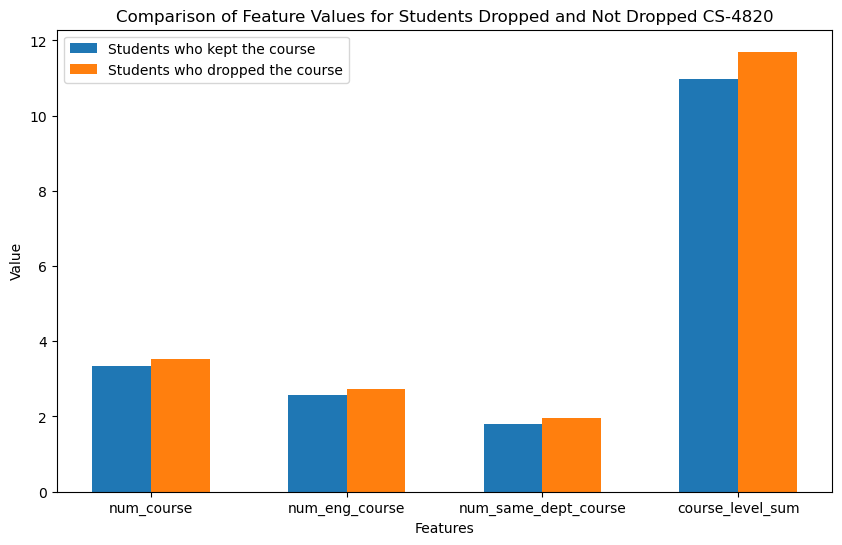

In [39]:
plotMean("CS-4820")

552 students pre-enrolled in PHYS-2214
1 data point is nan during processing
Sanity check passed
37 students dropped


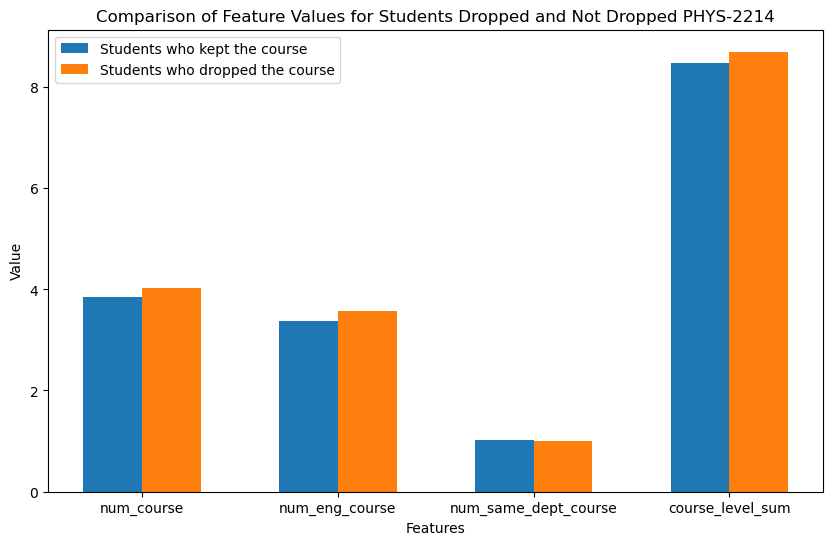

In [40]:
plotMean("PHYS-2214")

1203 students pre-enrolled in MATH-1110
4 data point is nan during processing
Sanity check passed
110 students dropped


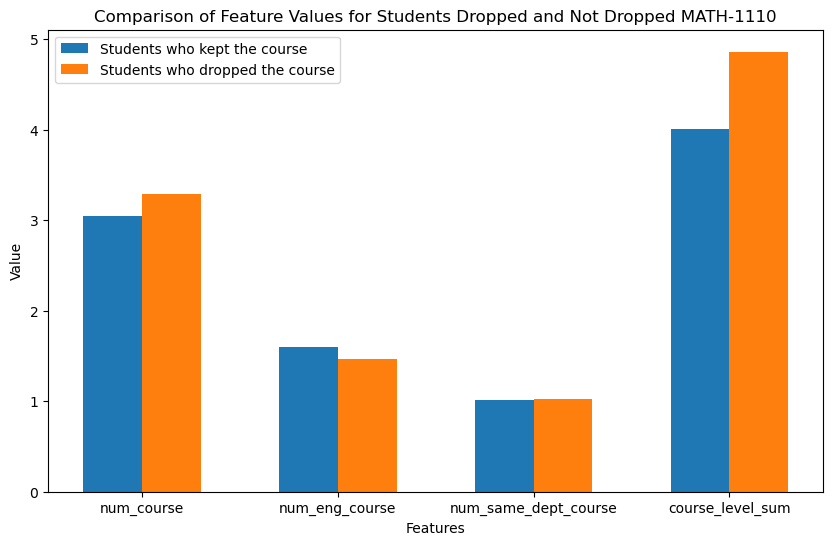

In [41]:
plotMean("MATH-1110")

In [13]:
selected = df[df['course'].isin(eng_filtered_exams)]
selected.loc[selected['Term'] == 2825, 'Term'] = 'fa22'
selected.loc[selected['Term'] == 2811, 'Term'] = 'sp22'
selected.loc[selected['Term'] == 2839, 'Term'] = 'sp23'
selected.head()

/var/folders/7s/c6ckxr1s2hg7gxv4jrpk5d_00000gn/T/ipykernel_99924/3207014116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected.loc[selected['Term'] == 2825, 'Term'] = 'fa22'


,Unnamed: 0,index,ID,Term,Class Nbr,Course ID,Offer Nbr,Subject,Catalog,Descr,Component,Class Stat,Cap Enrl,Tot Enrl,Acad Org,CrsAtr Val,Final Exam,course,If_Drop
10449,10449,3667,5419530,fa22,9013,350653,1,CEE,5900,Project Management,LEC,A,200,74,CEE,PRIMRES,Y,CEE-5900,0
10450,10450,2236,4483329,fa22,9013,350653,1,CEE,5900,Project Management,LEC,A,200,74,CEE,PRIMRES,Y,CEE-5900,0
10451,10451,2607,5445089,fa22,9013,350653,1,CEE,5900,Project Management,LEC,A,200,74,CEE,PRIMRES,Y,CEE-5900,0
10452,10452,284,5450056,fa22,9013,350653,1,CEE,5900,Project Management,LEC,A,200,74,CEE,PRIMRES,Y,CEE-5900,0
10453,10453,3898,5139004,fa22,9013,350653,1,CEE,5900,Project Management,LEC,A,200,74,CEE,PRIMRES,Y,CEE-5900,0


In [14]:
columns = ['num_course', 'num_eng_course', 'num_same_dept_course', 'course_level_sum']
def plotDep(dep):
    dep = selected[selected['Subject'] == dep]
    depdf = pd.DataFrame()
    l = dep['course'].unique()
    for c in l:
        course = feature_engineer(c)
        course['course'] = c
        depdf = pd.concat([depdf, course], axis = 0)
        
    grouped_df = depdf.groupby('dropped')[columns].mean()
    data = grouped_df.reset_index()
    positions = np.arange(len(columns))

    bar_width = 0.3

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, status in enumerate(data['dropped']):
        values = [data[column][i] for column in columns]
        ax.bar(positions + (i * bar_width), values, width=bar_width, label=f'Dropped = {status}')

    ax.set_xlabel('Features')
    ax.set_ylabel('Value')
    ax.set_title('Comparison of Feature Values for Students Dropped and Not Dropped the class')
    plt.xticks(positions + bar_width / 2, columns)
    plt.legend()
    plt.show()

61 students pre-enrolled in ORIE-4152
0 data point is nan during processing
Sanity check passed
12 students dropped
111 students pre-enrolled in ORIE-4600
2 data point is nan during processing
Sanity check passed
16 students dropped
173 students pre-enrolled in ORIE-5270
4 data point is nan during processing
Sanity check passed
7 students dropped
19 students pre-enrolled in ORIE-5510
2 data point is nan during processing
Sanity check passed
7 students dropped
46 students pre-enrolled in ORIE-5640
0 data point is nan during processing
Sanity check passed
9 students dropped
28 students pre-enrolled in ORIE-7391
0 data point is nan during processing
Sanity check passed
3 students dropped


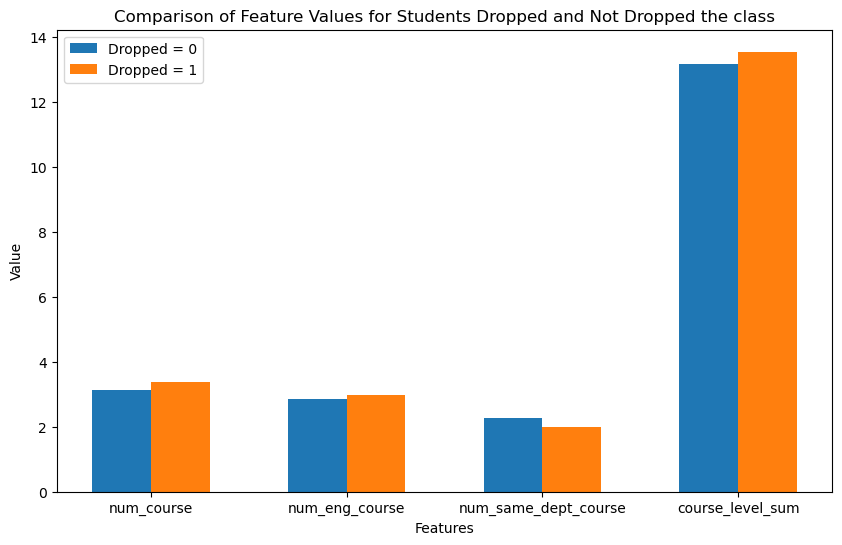

In [15]:
plotDep('ORIE')

186 students pre-enrolled in CEE-5900
2 data point is nan during processing
Sanity check passed
13 students dropped
845 students pre-enrolled in CHEM-2070
0 data point is nan during processing
Sanity check passed
14 students dropped
801 students pre-enrolled in CHEM-2090
1 data point is nan during processing
Sanity check passed
39 students dropped
1889 students pre-enrolled in CS-1110
15 data point is nan during processing
Sanity check passed
92 students dropped
432 students pre-enrolled in CS-1112
4 data point is nan during processing
Sanity check passed
27 students dropped
1669 students pre-enrolled in CS-2110
20 data point is nan during processing
Sanity check passed
116 students dropped
1369 students pre-enrolled in CS-2800
9 data point is nan during processing
Sanity check passed
73 students dropped
790 students pre-enrolled in CS-4410
4 data point is nan during processing
Sanity check passed
22 students dropped
776 students pre-enrolled in CS-4820
3 data point is nan during proce

95 students pre-enrolled in MAE-4860
0 data point is nan during processing
Sanity check passed
15 students dropped
159 students pre-enrolled in MAE-5010
6 data point is nan during processing
Sanity check passed
13 students dropped
19 students pre-enrolled in MAE-5230
1 data point is nan during processing
Sanity check passed
4 students dropped
418 students pre-enrolled in MATH-1106
0 data point is nan during processing
Sanity check passed
27 students dropped
177 students pre-enrolled in MATH-1340
3 data point is nan during processing
Sanity check passed
30 students dropped
63 students pre-enrolled in MATH-2130
0 data point is nan during processing
Sanity check passed
12 students dropped
65 students pre-enrolled in MATH-3040
1 data point is nan during processing
Sanity check passed
16 students dropped
57 students pre-enrolled in MATH-4180
0 data point is nan during processing
Sanity check passed
10 students dropped
53 students pre-enrolled in MATH-4340
1 data point is nan during processi

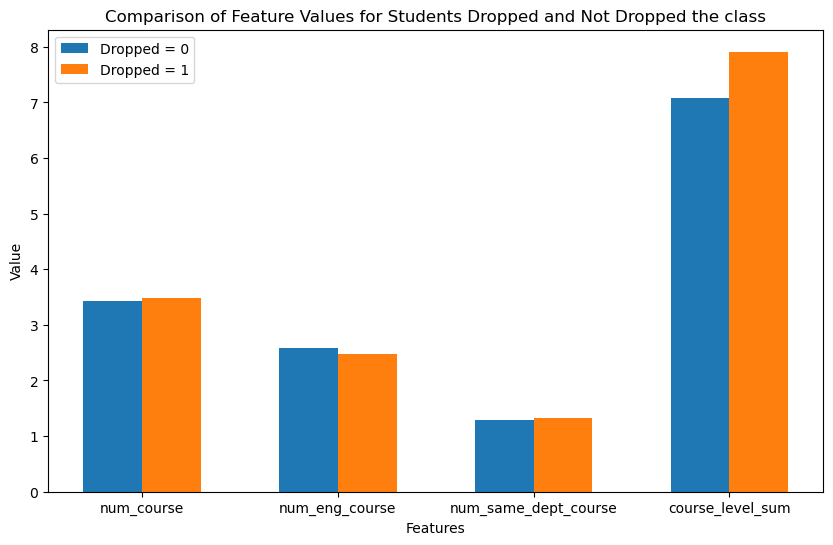

In [16]:
dep = selected
depdf = pd.DataFrame()
l = dep['course'].unique()
for c in l:
    course = feature_engineer(c)
    course['course'] = c
    depdf = pd.concat([depdf, course], axis = 0)

grouped_df = depdf.groupby('dropped')[columns].mean()
data = grouped_df.reset_index()
positions = np.arange(len(columns))

bar_width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))
for i, status in enumerate(data['dropped']):
    values = [data[column][i] for column in columns]
    ax.bar(positions + (i * bar_width), values, width=bar_width, label=f'Dropped = {status}')

ax.set_xlabel('Features')
ax.set_ylabel('Value')
ax.set_title('Comparison of Feature Values for Students Dropped and Not Dropped the class')
plt.xticks(positions + bar_width / 2, columns)
plt.legend()
plt.show()

In [17]:
import seaborn as sns
def groupby(dep):
    dep = selected[selected['Subject']== dep]
    group = dep.groupby(['Term','course'])['If_Drop'].sum().reset_index()
    print(group)
    sns.barplot(x='course', y='If_Drop', hue='Term', data=group)
    # Add labels and title
    plt.xlabel('Course')
    plt.ylabel('Number of Students who dropped the class')
    plt.title('Number of Drops by Course and Term')
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')

    # Display the graph
    plt.show()

    Term   course  If_Drop
0   fa22  CS-1110       18
1   fa22  CS-1112        6
2   fa22  CS-2110       16
3   fa22  CS-2800       10
4   fa22  CS-4410        2
5   fa22  CS-4820        9
6   sp22  CS-1110        3
7   sp22  CS-1112        2
8   sp22  CS-1380        2
9   sp22  CS-1710        3
10  sp22  CS-2110       17
11  sp22  CS-2800        4
12  sp22  CS-4410        2
13  sp22  CS-4670        3
14  sp22  CS-4820        9
15  sp22  CS-4852        3
16  sp23  CS-1110       97
17  sp23  CS-1112       23
18  sp23  CS-1380       24
19  sp23  CS-1710        9
20  sp23  CS-2110      103
21  sp23  CS-2800       68
22  sp23  CS-4410       22
23  sp23  CS-4670       45
24  sp23  CS-4820       15
25  sp23  CS-4852       38


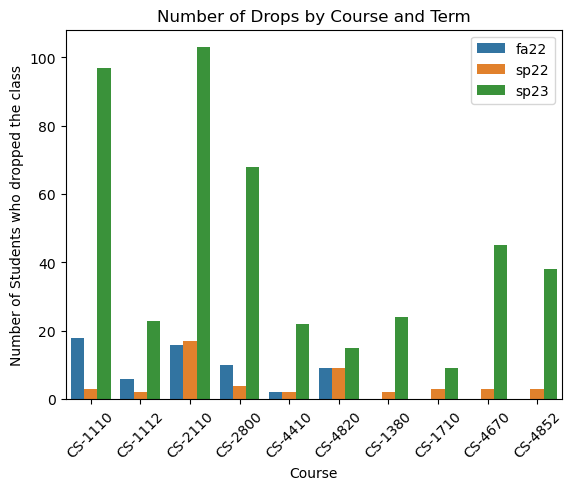

In [18]:
groupby('CS')

    Term     course  If_Drop
0   sp22  ORIE-4152        3
1   sp22  ORIE-4600        5
2   sp22  ORIE-5270        3
3   sp22  ORIE-5510        4
4   sp22  ORIE-5640        6
5   sp22  ORIE-7391        1
6   sp23  ORIE-4152        9
7   sp23  ORIE-4600       13
8   sp23  ORIE-5270        8
9   sp23  ORIE-5510        5
10  sp23  ORIE-5640        3
11  sp23  ORIE-7391        2


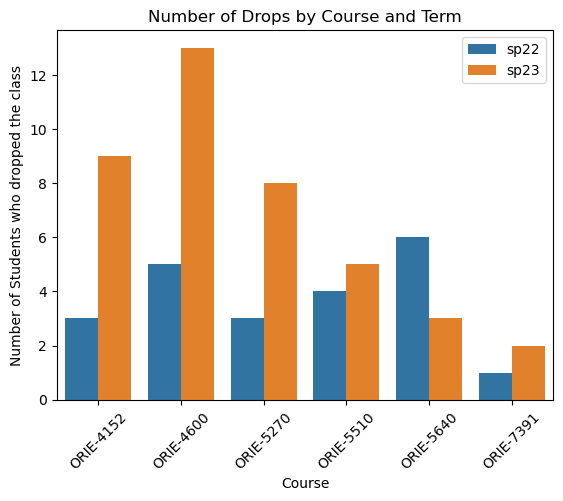

In [19]:
groupby('ORIE')

    Term     course  If_Drop
0   fa22  MATH-1110       42
1   fa22  MATH-1120       11
2   fa22  MATH-1710        5
3   fa22  MATH-1920        6
4   fa22  MATH-2210        8
5   fa22  MATH-2940        4
6   fa22  MATH-3110        2
7   fa22  MATH-3340        2
8   fa22  MATH-4710        3
9   sp22  MATH-1106        2
10  sp22  MATH-1110       19
11  sp22  MATH-1120        7
12  sp22  MATH-1340        1
13  sp22  MATH-1710        4
14  sp22  MATH-1920       14
15  sp22  MATH-2130        2
16  sp22  MATH-2210        4
17  sp22  MATH-2940       11
18  sp22  MATH-3040        3
19  sp22  MATH-3110        1
20  sp22  MATH-3340        2
21  sp22  MATH-4180        2
22  sp22  MATH-4340        2
23  sp22  MATH-4710        1
24  sp22  MATH-4740        2
25  sp23  MATH-1106       38
26  sp23  MATH-1110      128
27  sp23  MATH-1120       85
28  sp23  MATH-1340       36
29  sp23  MATH-1710       23
30  sp23  MATH-1920      112
31  sp23  MATH-2130       10
32  sp23  MATH-2210       47
33  sp23  MATH

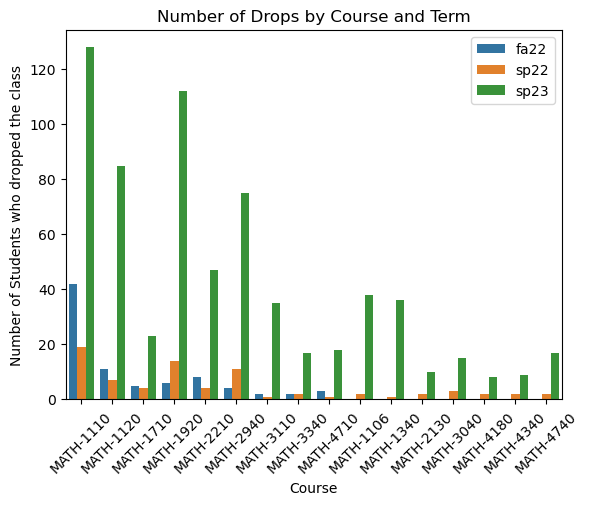

In [20]:
groupby('MATH')

    Term     course  If_Drop
0   fa22  PHYS-1112        1
1   fa22  PHYS-1116        2
2   fa22  PHYS-2213        7
3   fa22  PHYS-2214        8
4   sp22  PHYS-1112        4
5   sp22  PHYS-1116        1
6   sp22  PHYS-2208        3
7   sp22  PHYS-2213        2
8   sp22  PHYS-2214        5
9   sp22  PHYS-3318        1
10  sp23  PHYS-1112       82
11  sp23  PHYS-1116        2
12  sp23  PHYS-2208       42
13  sp23  PHYS-2213       45
14  sp23  PHYS-2214       45
15  sp23  PHYS-3318        4


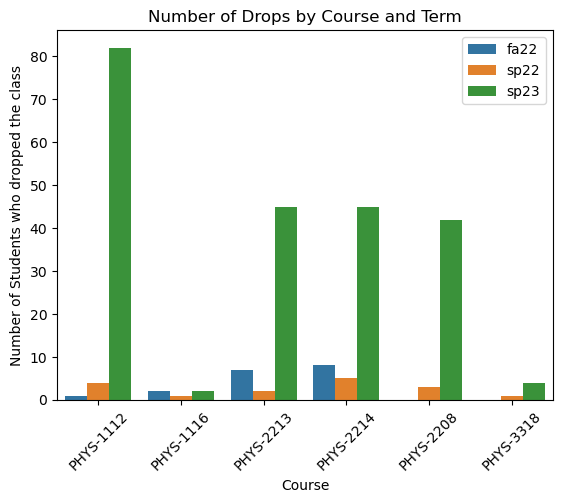

In [21]:
groupby('PHYS')